# # 1-  Build models for ECMWF IFS forecasts
# # RMSE=f($\sigma( \Delta k_c)$)

In [19]:
import pandas as pd

# Load the ECMWF IFS RMSE results
file_path = '../data/results_da_ecmwf.csv'
data = pd.read_csv(file_path)

# meanObs : mean GHI
# stddeltakc : site Variability
# IFS : ECMWF RMSE
columns_to_process = ['IFS']

# compute relative counterparts
for col in columns_to_process:
    new_col = f'{col}r'
    data[new_col] = (data[col] / data['meanObs']) * 100


data.head()
#data.to_latex('Test.tex')

,Site,meanObs,stdkc,stddeltakc,meanabslogr,IFS,IFSr
0,ADR,580.583028,0.161909,0.118460,0.077593,73.858086,12.721365
1,ALB,527.197792,0.236791,0.179388,0.189130,115.170165,21.845722
2,ALI,597.057485,0.213251,0.131771,0.106704,94.891546,15.893201
3,BAR,297.138528,0.281878,0.127593,0.149270,96.818719,32.583697
4,BUR,455.528951,0.242905,0.168271,0.178479,103.539099,22.729422


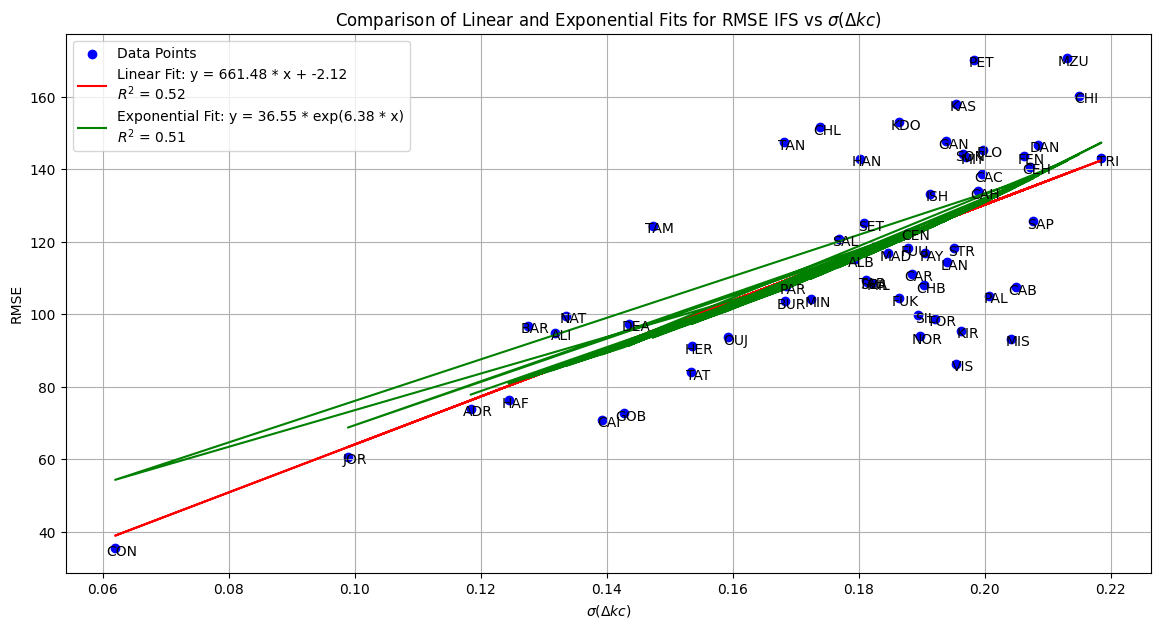

Linear Fit R²: 0.52
Exponential Fit R²: 0.51
Linear Fit Pearson Correlation: 0.72, P-value: 7.55e-11
Exponential Fit Pearson Correlation: 0.72, P-value: 1.20e-10


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# Load the data
file_path = '../data/results_da_ecmwf.csv'
data = pd.read_csv(file_path)

# Define the fields to analyze
field = 'IFS'

# Extract the variables
X = data[['stddeltakc']].values.reshape(-1, 1)
y = data[field].values

# Linear regression
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_linear_pred = linear_regressor.predict(X)
linear_r2 = r2_score(y, y_linear_pred)

# Exponential regression
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Initial guess for the parameters
initial_guess = [1, 0.1]

# Fit the exponential model
params, covariance = curve_fit(exponential_model, X.flatten(), y, p0=initial_guess)
y_exp_pred = exponential_model(X.flatten(), *params)
exp_r2 = r2_score(y, y_exp_pred)

# Pearson correlation for linear fit
pearson_corr_linear, p_value_linear = pearsonr(y, y_linear_pred)

# Pearson correlation for exponential fit
pearson_corr_exp, p_value_exp = pearsonr(y, y_exp_pred)

# Plotting the data and the fits
plt.figure(figsize=(14, 7))

# Scatter plot
plt.scatter(X, y, label='Data Points', color='blue')

# Plot linear fit
plt.plot(X, y_linear_pred, label=f'Linear Fit: y = {linear_regressor.coef_[0]:.2f} * x + {linear_regressor.intercept_: .2f}\n$R^2$ = {linear_r2:.2f}', color='red')

# Plot exponential fit
plt.plot(X, y_exp_pred, label=f'Exponential Fit: y = {params[0]:.2f} * exp({params[1]:.2f} * x)\n$R^2$ = {exp_r2:.2f}', color='green')

# Annotate each point with the site name
for i, row in data.iterrows():
    plt.annotate(row['Site'], (row['stddeltakc'], row[field]), textcoords="offset points", xytext=(5, -5), ha='center')

plt.title(f'Comparison of Linear and Exponential Fits for RMSE {field} vs $\\sigma (\\Delta kc)$')
plt.xlabel('$\\sigma (\\Delta kc)$')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
print(f'Linear Fit R²: {linear_r2:.2f}')
print(f'Exponential Fit R²: {exp_r2:.2f}')
print(f'Linear Fit Pearson Correlation: {pearson_corr_linear:.2f}, P-value: {p_value_linear:.2e}')
print(f'Exponential Fit Pearson Correlation: {pearson_corr_exp:.2f}, P-value: {p_value_exp:.2e}')



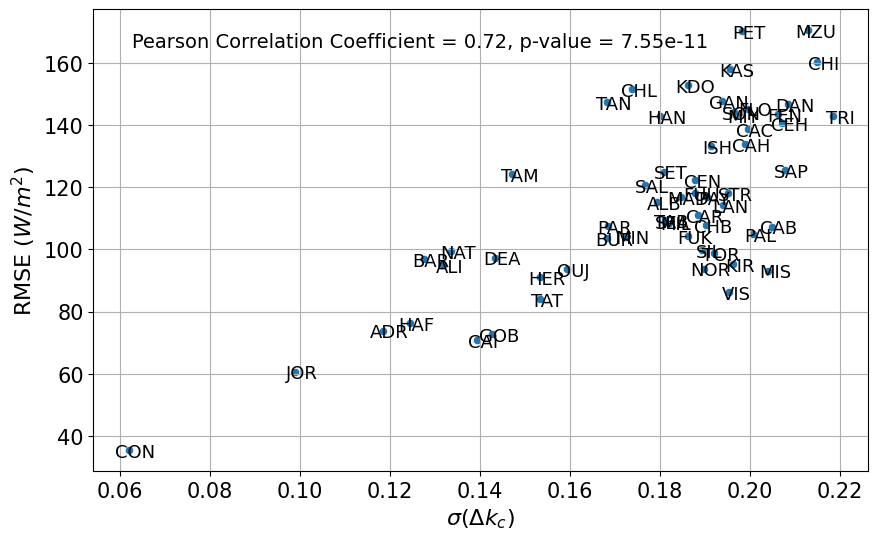

Pearson Correlation Coefficient: 0.72
P-value: 7.549319247749829e-11
Regression Equation day-ahead IFS forecasts : 661.48*X -2.12
R^2: 0.52


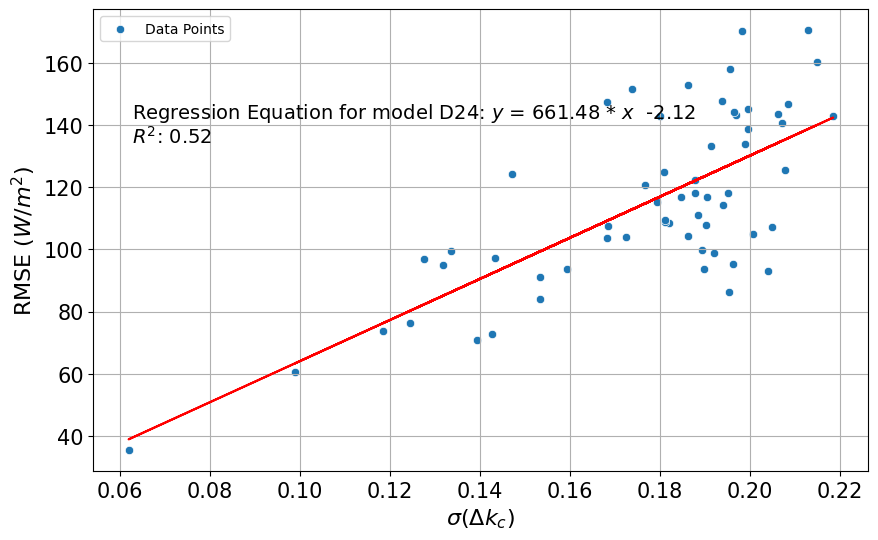

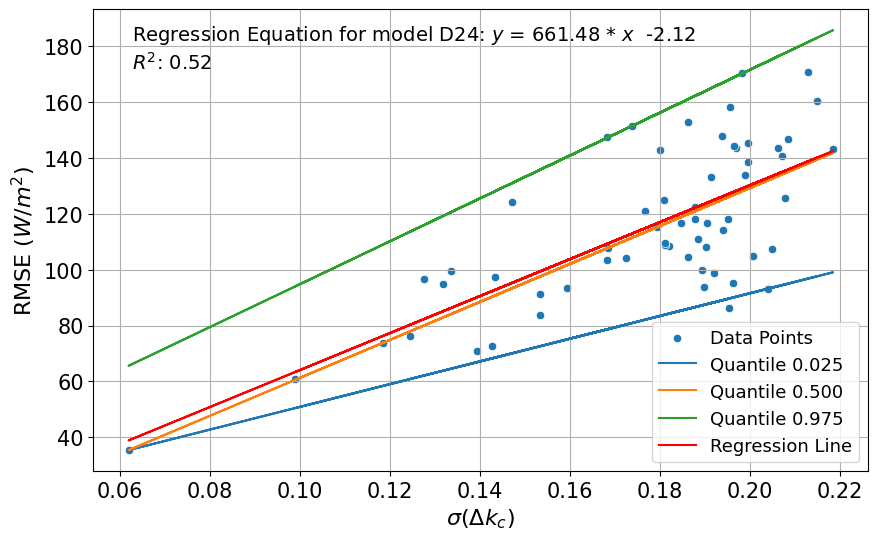

Quantile 0.025: 10.21, 406.53
Quantile 0.500: -6.70, 679.38
Quantile 0.975: 18.02, 767.26


In [23]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import pandas as pd
import statsmodels.api as sm
import numpy as np



# Step 1: Summary Statistics
summary_statistics = data[['stddeltakc', 'IFS']].describe()

# Step 2: Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stddeltakc', y='IFS', data=data)
# Step 3: Correlation Coefficient
correlation_coefficient, p_value = pearsonr(data['stddeltakc'], data['IFS'])
# Annotate each point with the site name
for i, row in data.iterrows():
    plt.annotate(row['Site'], (row['stddeltakc'], row['IFS']), textcoords="offset points", xytext=(5,-5), ha='center',fontsize=13)

#plt.text(0.05, 0.95, f'Pearson Correlation Coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes, 
#             fontsize=12, verticalalignment='top')
plt.text(0.05, 0.95, f'Pearson Correlation Coefficient = {correlation_coefficient:.2f}, p-value = {p_value:.2e}', transform=plt.gca().transAxes,fontsize=14, verticalalignment='top')
#plt.title('Scatter Plot of Rmse vs $\sigma ( \Delta kc)$  - Day ahead IFS forecasts')
plt.xlabel('$\\sigma (\\Delta k_c)$',fontsize=16)
plt.ylabel('RMSE $(W/m^2)$',fontsize=16)
plt.xticks(fontsize=15)   
plt.yticks(fontsize=15) 
plt.grid(True)
plt.savefig('../figures/day-ahead_rmse_vs_stddeltakc.png', format='png')
plt.show()



# Step 4: Regression Analysis
X = data[['stddeltakc']].values.reshape(-1, 1)
y = data['IFS'].values

regressor = LinearRegression()
regressor.fit(X, y)
y_D24 = regressor.predict(X)

# Regression coefficients
regression_coef = regressor.coef_[0]
regression_intercept = regressor.intercept_

#Correlation Analysis
print(f'Pearson Correlation Coefficient: {correlation_coefficient:.2f}')
print(f'P-value: {p_value}')
# regression equation
print(f'Regression Equation day-ahead IFS forecasts : {regression_coef:5.2f}*X {regression_intercept:5.2f}')
# Regression equation
regression_eq = f'Regression Equation for model D24: $y$ = {regression_coef:.2f} * $x$  {regression_intercept:.2f}'
    
    
r2 = r2_score(y, y_D24 )
r2_text = f'$R^2$: {r2:.2f}'
print(f'R^2: {r2:.2f}')

# Plotting the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stddeltakc', y='IFS', data=data, label='Data Points')
#plt.plot(data['stddeltakc'], y_pred, color='red', label='Regression Line')
plt.plot(X, y_D24, color='red', label='Regression Line')
plt.text(0.05, 0.80, regression_eq, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.05, 0.75, r2_text, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')


#plt.title('Linear Regression of Rmse day-ahead IFS vs $\sigma ( \Delta kc)$ ')
plt.xlabel('$\\sigma (\\Delta k_c)$',fontsize=16)
plt.ylabel('RMSE $(W/m^2)$',fontsize=16)
plt.xticks(fontsize=15)   
plt.yticks(fontsize=15) 
plt.grid(True)
plt.savefig('../figures/day-ahead_linearfit.png', format='png')
plt.show()

xx = data[['stddeltakc']].values.reshape(-1, 1)
# Define the quantiles

quantiles =(0.025, 0.5, 0.975);

# Add a constant to the predictor variable for the intercept term
X = sm.add_constant(xx)  # Convert to numpy array

# Perform quantile regression and store the results
quantile_regressions = [sm.QuantReg(data['IFS'].values, X).fit(q=q) for q in quantiles]

# Extract the predictions for each quantile
quantile_predictions = {q: qr.predict(X) for q, qr in zip(quantiles, quantile_regressions)}

# Plotting the quantile regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stddeltakc', y='IFS', data=data, label='Data Points')

for q in quantiles:
    plt.plot(xx, quantile_predictions[q], label=f'Quantile {q:.3f}')

plt.plot(xx, y_D24, color='red', label='Regression Line')
plt.text(0.05, 0.97, regression_eq, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.05, 0.91, r2_text, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
#plt.title('Quantile Regression of Rmse day-ahead IFS forecasts vs $\sigma ( \Delta kc)$')
plt.xlabel('$\\sigma (\\Delta k_c)$',fontsize=16)
plt.ylabel('RMSE $(W/m^2)$',fontsize=16)
plt.xticks(fontsize=15)   
plt.yticks(fontsize=15) 
plt.legend(fontsize=13)  # Change fontsize as needed
plt.grid(True)
plt.savefig('../figures/day-ahead_quantilereg.png', format='png')
plt.show()

# Display the quantile regression coefficients
quantile_coefficients = {q: qr.params for q, qr in zip(quantiles, quantile_regressions)}
for q, params in quantile_coefficients.items():
        formatted_params = ", ".join([f"{param:.2f}" for param in params])
        print(f'Quantile {q:.3f}: {formatted_params}')




#Determine conditional quantiles for day-ahead forecasts

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/var/folders/k0/d36_zr2928g0n5n14wp4gdmc0000gn/T/ipykernel_65604/1520632256.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Quantile Regression of Rmse day-ahead IFS forecasts vs $\sigma ( \Delta kc)$')
/var/folders/k0/d36_zr2928g0n5n14wp4gdmc0000gn/T/ipykernel_65604/1520632256.py:31: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma ( \Delta kc)$')


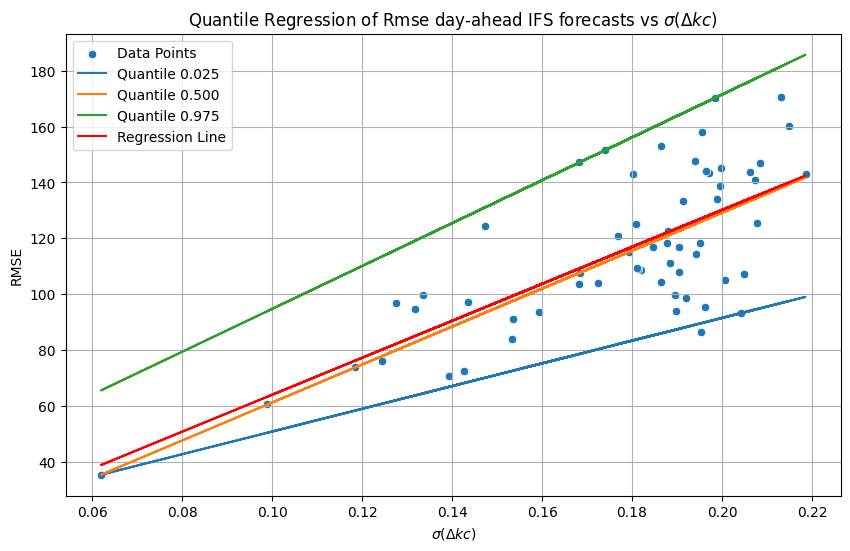

Quantile 0.025: 10.21, 406.53
Quantile 0.500: -6.70, 679.38
Quantile 0.975: 18.02, 767.26


In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np


xx = data[['stddeltakc']].values.reshape(-1, 1)
# Define the quantiles

quantiles =(0.025, 0.5, 0.975);

# Add a constant to the predictor variable for the intercept term
X = sm.add_constant(xx)  # Convert to numpy array

# Perform quantile regression and store the results
quantile_regressions = [sm.QuantReg(data['IFS'].values, X).fit(q=q) for q in quantiles]

# Extract the predictions for each quantile
quantile_predictions = {q: qr.predict(X) for q, qr in zip(quantiles, quantile_regressions)}

# Plotting the quantile regression lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stddeltakc', y='IFS', data=data, label='Data Points')

for q in quantiles:
    plt.plot(xx, quantile_predictions[q], label=f'Quantile {q:.3f}')

plt.plot(xx, y_D24, color='red', label='Regression Line')
plt.title('Quantile Regression of Rmse day-ahead IFS forecasts vs $\sigma ( \Delta kc)$')
plt.xlabel('$\sigma ( \Delta kc)$')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.savefig('../figures/day-ahead_quantilereg.png', format='png')
plt.show()

# Display the quantile regression coefficients
quantile_coefficients = {q: qr.params for q, qr in zip(quantiles, quantile_regressions)}
for q, params in quantile_coefficients.items():
        formatted_params = ", ".join([f"{param:.2f}" for param in params])
        print(f'Quantile {q:.3f}: {formatted_params}')


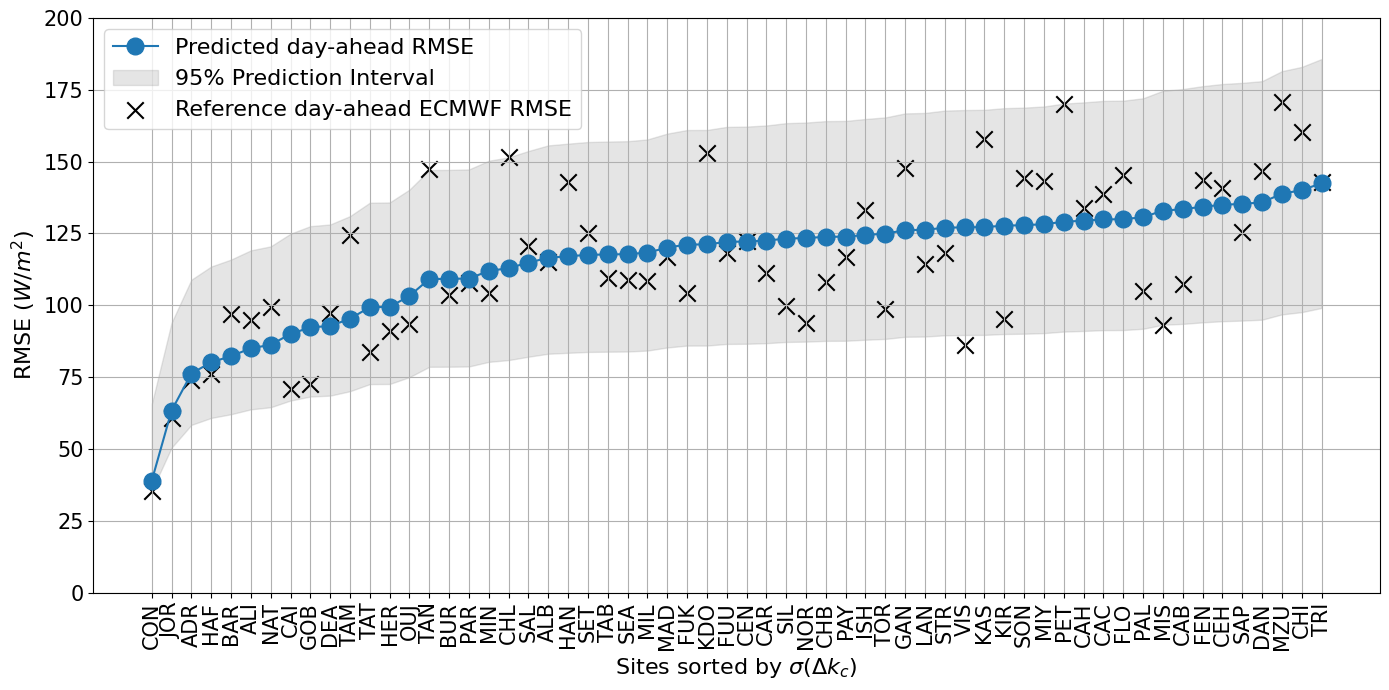

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def D24_2_5(stddeltakc):
    return 10.21 + 406.53 * stddeltakc

def D24_50(stddeltakc):
    return -6.70 + 679.38 * stddeltakc

def D24_97_5(stddeltakc):
    return 18.02 + 767.26 * stddeltakc

def D24(stddeltakc):
    return 661.48 * stddeltakc - 2.12


# Load the CSV file
file_path = '../data/results_da_ecmwf.csv'
data = pd.read_csv(file_path)


plt.figure(figsize=(14, 7))
    
# Initialize lists for plotting
site_names = []
reg_preds = []
lower_preds = []
upper_preds = []
effective_rmses = []
    
# For all 60 sites, collect data and sort by stddeltakc
site_data_sorted = data.sort_values(by='stddeltakc')  # Sort sites by stddeltakc
for _, site_row in site_data_sorted.iterrows():
    site = site_row['Site']
    X_site = site_row['stddeltakc']
        
    # Calculate regression and prediction intervals directly on the float X_site
    reg_pred = D24(X_site)
    lower_pred = D24_2_5(X_site)
    upper_pred = D24_97_5(X_site)
    effective_rmse = site_row['IFS']
        
    # Append data to lists for plotting
    site_names.append(site)
    reg_preds.append(reg_pred)
    lower_preds.append(lower_pred)
    upper_preds.append(upper_pred)
    effective_rmses.append(effective_rmse)
    
# Convert lists to numpy arrays for plotting
reg_preds = np.array(reg_preds).flatten()
lower_preds = np.array(lower_preds).flatten()
upper_preds = np.array(upper_preds).flatten()
effective_rmses = np.array(effective_rmses).flatten()
    
# Plot the regression line and error bars for each site
#plt.errorbar(site_names, reg_preds, yerr=[reg_preds - lower_preds, upper_preds - reg_preds], fmt='o', label='Regression Prediction', capsize=5)
plt.plot(site_names, reg_preds,marker='o',label='Predicted day-ahead RMSE',markersize=12)
plt.fill_between(site_names, lower_preds, upper_preds, color='gray', alpha=0.2, label='95% Prediction Interval')
# Plot the effective RMSE with cross markers
plt.scatter(site_names, effective_rmses, marker='x', color='black', label='Reference day-ahead ECMWF RMSE',s=140)
    
# Customize plot for this horizon
#plt.title(f'RMSE vs Sites')
plt.xlabel('Sites sorted by $\\sigma (\\Delta k_c)$',fontsize=16)
plt.ylabel('RMSE $(W/m^2$)',fontsize=16)
plt.xticks(rotation=90,fontsize=15)  # Rotate site names for better visibility
plt.yticks(fontsize=15) 
plt.legend(fontsize=16)  # Change fontsize as needed
plt.ylim(0, 200)  # Set your desired y-axis limits here
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/day-ahead_rmse_vs_all_sites.png', format='png')
plt.show()


In [29]:
import pandas as pd

# Load the CSV file
file_path = '../data/test_da_ecmwf_model.csv'
v_data = pd.read_csv(file_path)

# compute relative counterparts
# List of the columns to process
columns_to_process = ['IFS']

# Compute the new columns using a for loop
for col in columns_to_process:
    new_col = f'{col}r'
    v_data[new_col] = (v_data[col] / v_data['meanObs']) * 100

In [31]:
# Define the models
# models day-ahead
# D24  quantile regression model :
# y_2.5%= 10.20916048 + 406.52870646*X
#   y_50%: -6.70167947 +  679.37674734 *X, 
#    y_97.5%: 18.02345029 +  767.26009425*X
#    Regression Equation  : 663.84*X -2.59

def D24_2_5(stddeltakc):
    return 10.21 + 406.53 * stddeltakc

def D24_50(stddeltakc):
    return -6.70+ 679.38 * stddeltakc

def D24_97_5(stddeltakc):
    return 18.02  + 767.26 * stddeltakc

def D24(stddeltakc):
    return 661.48 * stddeltakc -2.12

    
# Create predictions file
# 
columns = ['Site', 'meanObs', 'stddeltakc', 'IFS', 'IFSr']
o_data = pd.DataFrame(columns=columns)
o_data['Site'] = v_data['Site']
o_data['meanObs'] = v_data['meanObs']
o_data['stddeltakc'] = v_data['stddeltakc']
o_data['IFS'] = v_data[col]
o_data['IFSr'] = (v_data[col] / v_data['meanObs']) * 100
    
# Save predictions

# Calculate the predictions
o_data['D24_2_5'] = v_data['stddeltakc'].apply(D24_2_5)
o_data['D24_50'] = v_data['stddeltakc'].apply(D24_50)
o_data['D24_97_5'] = v_data['stddeltakc'].apply(D24_97_5)
o_data['D24'] = v_data['stddeltakc'].apply(D24)
# Save the updated DataFrame to a new CSV file
output_file_path = '../data/predictions_D24_model.csv'
o_data.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")


Predictions saved to ../data1/predictions_D24_model.csv


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '../data/predictions_D24_model.csv'
v_data = pd.read_csv(file_path)

# Add day-ahead RMSE data
# Load Perez's results
# Perez et al, 2013
file_path = '../data/results_perez2013_d.csv'
pr1_data = pd.read_csv(file_path)
# Perez et al, 2018
file_path = '../data/results_perez2018_d.csv'
pr2_data = pd.read_csv(file_path)
# Load Yang's results
# Yang et al, 2019a
file_path = '../data/results_yang2019a_d.csv'
dy1_data = pd.read_csv(file_path)
# Yang et al, 2019b
file_path = '../data/results_yang2019b_d.csv'
dy2_data = pd.read_csv(file_path)

v_data['D24_pr1'] = pr1_data['D24']
v_data['D24_pr2'] = pr2_data['D24']
v_data['D24_dy1'] = dy1_data['D24']
v_data['D24_dy2'] = dy2_data['D24']

v_data['meanO_pr1_d'] = pr1_data['meanObs']
v_data['meanO_pr2_d'] = pr2_data['meanObs']
v_data['meanO_dy1'] = dy1_data['meanObs']
v_data['meanO_dy2'] = dy2_data['meanObs']


#v_data.head()
v_data.tail()

,Site,meanObs,stddeltakc,IFS,IFSr,D24_2_5,D24_50,D24_97_5,D24,D24_pr1,D24_pr2,D24_dy1,D24_dy2,meanO_pr1_d,meanO_pr2_d,meanO_dy1,meanO_dy2
2,fpk,349.443527,0.177964,124.559995,35.645243,82.557715,114.205199,154.564677,115.599643,104.32,98.9850,131.17,83.0754,326,359.9456,432.4761,359.9456
3,gwn,409.515658,0.175368,136.187587,33.255770,81.502307,112.441435,152.572765,113.882350,112.53,98.8624,157.39,90.0491,363,383.1877,492.4593,383.1877
4,psu,352.472682,0.188562,136.981545,38.863025,86.865982,121.405039,162.695840,122.609784,116.22,105.6288,154.99,92.6103,298,336.3976,441.4412,336.3976
5,sxf,370.072951,0.183283,138.708737,37.481458,84.719970,117.818690,158.645586,119.117928,124.64,94.6235,145.08,90.3513,328,353.0727,448.7473,353.0727
6,tbl,427.299069,0.209909,143.344614,33.546671,95.544484,135.908274,179.075115,136.730895,142.12,111.2791,163.67,102.3686,374,410.6240,502.6720,410.6240


/Users/lauret/myenv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


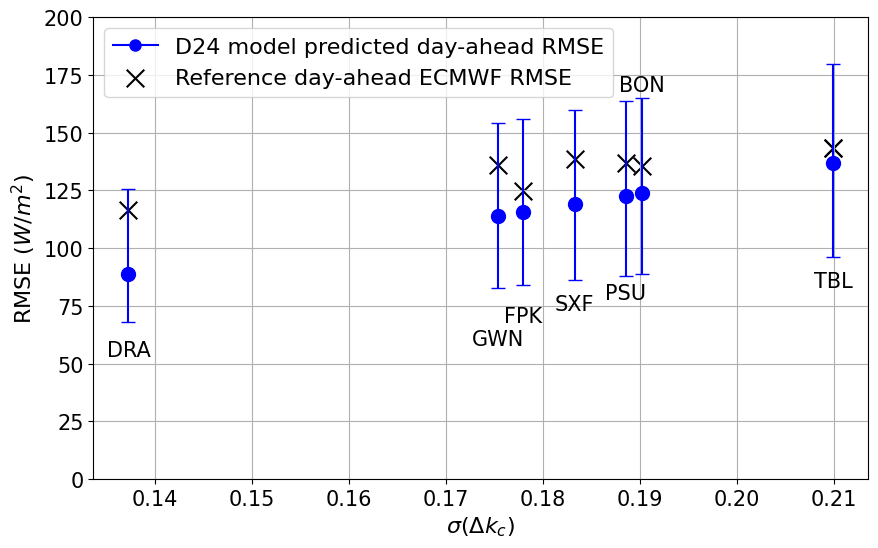

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '../data/predictions_D24_model.csv'
v_data = pd.read_csv(file_path)

def plot_with_error_bars(site_data, site_name, model, horizon):
    x = site_data['stddeltakc']
    
    # Model-specific data selection (assuming you're only using 'IFS')
    if model == 'D24':
        y_50 = site_data['D24_50']
        y_reg = site_data['D24']
        y2_5 = site_data['D24_2_5']
        y97_5 = site_data['D24_97_5']
        yerr = [y_50 - y2_5, y97_5 - y_50]
        
    x = x.values.flatten() if hasattr(x, 'values') else x
    y_reg = y_reg.values.flatten() if hasattr(y_reg, 'values') else y_reg


    # Plot data points and error bars
    plt.plot(x, y_reg, marker='o', markersize=10,color='blue')
    if site_name.upper()=='TBL' :
        plt.plot(x, y_reg, marker='o', markersize=8,color='blue',label='D24 model predicted day-ahead RMSE')
    plt.errorbar(x, y_reg, yerr=yerr, capsize=5, color='blue')
    # Define a mapping of site names to marker styles
    # Define specific x and y positions for the site names
    
    # Define specific x and y positions for the site names
    position_mapping = {
    'DRA': (0, 60),    # Position for example_site
    'GWN': (2, 65),    # Position for another_site
    'FPK': (3, 75),   # Position for yet_another_site
    'SXF': (3, 80),   # Position for yet_another_site
    'PSU': (3, 85),   # Position for yet_another_site
    'BON': (3, 175),   # Position for yet_another_site
    'TBL': (3, 90),   # Position for yet_another_site
    }

    # Get the specific positions for the current site name
    x_pos, y_pos = position_mapping.get(site_name.upper(), (x[0], y_reg[0]))  # Default to first position if not found
    
    for i in range(len(x)):
    # Dynamically adjust the y-position to avoid text overlap
        plt.text(x[0], y_pos, site_name.upper(), fontsize=15, ha='center', va='top')
    
    

# Plotting
plt.figure(figsize=(10, 6))

# Group by site and plot each site separately
grouped = v_data.groupby('Site')
for site_name, site_data in grouped:
    plot_with_error_bars(site_data, site_name, 'D24', '24h')
    # Adding the day-ahead data
    plt.scatter(site_data['stddeltakc'], site_data['IFS'], color='black', marker='x', s=160)
plt.scatter(site_data['stddeltakc'], site_data['IFS'], color='black',marker='x',label='Reference day-ahead ECMWF RMSE',s=160)
plt.ylim(0, 200)  # Set your desired y-axis limits here
plt.xlabel('$\\sigma (\\Delta k_c)$', fontsize=16)
plt.ylabel('RMSE $(W/m^2)$', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=15)   
plt.yticks(fontsize=15) 
plt.savefig('../figures/rmse_vs_stddeltakc_D24.png', format='png')
plt.show()


In [37]:
import pandas as pd

# Load the CSV file
file_path = '../data/results_da_ecmwf_extra.csv'
v_data = pd.read_csv(file_path)

# compute relative counterparts
# List of the columns to process
columns_to_process = ['IFS']

# Compute the new columns using a for loop
for col in columns_to_process:
    new_col = f'{col}r'
    v_data[new_col] = (v_data[col] / v_data['meanObs']) * 100
    
v_data.head()

,Site,meanObs,stdkc,stddeltakc,meanabslogr,IFS,IFSr
0,BAC,338.734146,0.310153,0.187090,0.284941,130.606157,38.557128
1,DWN,537.800267,0.247797,0.178563,0.199054,136.976124,25.469702
2,GHA,572.887893,0.162462,0.129102,0.085281,73.743093,12.872168
3,GUR,438.853425,0.225433,0.159998,0.170961,105.657607,24.075830
4,HOW,406.815999,0.241026,0.147302,0.161066,97.854042,24.053637


In [39]:
# Define the models
# models day-ahead
# D24 quantile regression model :
# y_2.5%= 10.20916048 + 406.52870646*X
#   y_50%: -6.70167947 +  679.37674734 *X, 
#    y_97.5%: 18.02345029 +  767.26009425*X
#    Regression Equation  : 663.84*X -2.59

def D24_2_5(stddeltakc):
    return 10.21 + 406.53 * stddeltakc

def D24_50(stddeltakc):
    return -6.70+ 679.38 * stddeltakc

def D24_97_5(stddeltakc):
    return 18.02  + 767.26 * stddeltakc

def D24(stddeltakc):
    return 661.48 * stddeltakc -2.12

    
# Create predictions file
# 
columns = ['Site', 'meanObs', 'stddeltakc', 'IFS', 'IFSr']
o_data = pd.DataFrame(columns=columns)
o_data['Site'] = v_data['Site']
o_data['meanObs'] = v_data['meanObs']
o_data['stddeltakc'] = v_data['stddeltakc']
o_data['IFS'] = v_data[col]
o_data['IFSr'] = (v_data[col] / v_data['meanObs']) * 100
    
# Save predictions

# Calculate the predictions
o_data['D24_2_5'] = v_data['stddeltakc'].apply(D24_2_5)
o_data['D24_50'] = v_data['stddeltakc'].apply(D24_50)
o_data['D24_97_5'] = v_data['stddeltakc'].apply(D24_97_5)
o_data['D24'] = v_data['stddeltakc'].apply(D24)
# Save the updated DataFrame to a new CSV file
output_file_path = '../data/predictions_D24_extra.csv'
o_data.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")



Predictions saved to ../data1/predictions_D24_extra.csv


<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
/var/folders/k0/d36_zr2928g0n5n14wp4gdmc0000gn/T/ipykernel_65604/3778356094.py:50: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$ \sigma (\Delta k_c)$',fontsize=16)
/var/folders/k0/d36_zr2928g0n5n14wp4gdmc0000gn/T/ipykernel_65604/3778356094.py:71: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$ \sigma (\Delta k_c)$')
/Users/lauret/myenv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


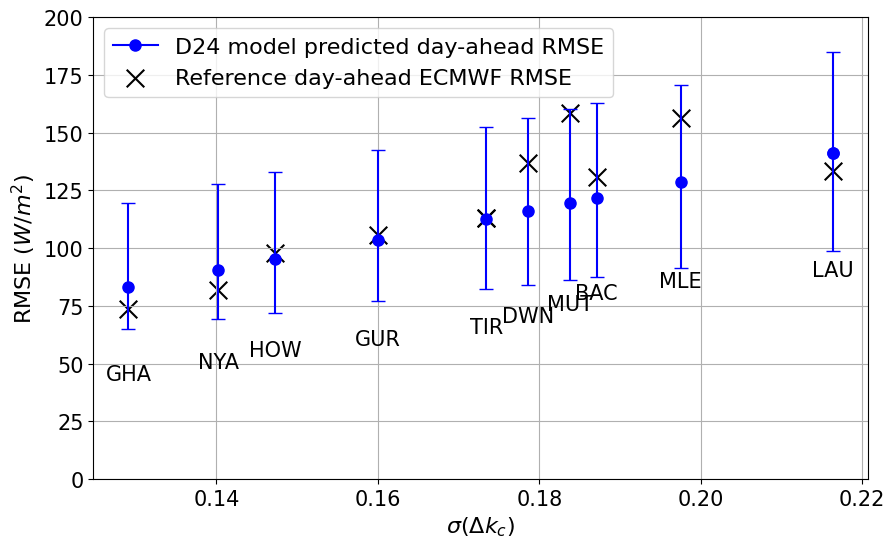

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '../data/predictions_D24_extra.csv'
v_data = pd.read_csv(file_path)


def plot_with_error_bars(site_data, site_name,model,horizon):
    x = site_data['stddeltakc']
    if model == 'D24':
        y_50 = site_data['D24_50']
        y = site_data['D24']
        y2_5 = site_data['D24_2_5']
        y97_5 = site_data['D24_97_5'] 
        yerr = [y_50-y2_5, y97_5-y_50]
        
    x = x.values.flatten() if hasattr(x, 'values') else x
    y = y.values.flatten() if hasattr(y, 'values') else y


    
    plt.plot(x, y, marker='o', markersize=8,color='blue')
    if site_name.upper()=='LAU' :
        plt.plot(x, y, marker='o', markersize=8,color='blue',label='D24 model predicted day-ahead RMSE')
    plt.errorbar(x, y, yerr=yerr, capsize=5, color='blue')

    # Define specific x and y positions for the site names
    position_mapping = {
    'GHA': (0, 50),    # Position for example_site
    'NYA': (2, 55),    # Position for another_site
    'HOW': (3, 60),   # Position for yet_another_site
    'GUR': (3, 65),   # Position for yet_another_site
    'TIR': (3, 70),   # Position for yet_another_site
    'DWN': (3, 75),   # Position for yet_another_site
    'MUT': (3, 80),   # Position for yet_another_site
    'BAC': (3, 85),   # Position for yet_another_site
    'MLE': (3, 90),   # Position for yet_another_site
    'LAU': (3, 95),   # Position for yet_another_site
    }

    # Get the specific positions for the current site name
    x_pos, y_pos = position_mapping.get(site_name.upper(), (x[0], y[0]))  # Default to first position if not found
    
    for i in range(len(x)):
    # Dynamically adjust the y-position to avoid text overlap
        plt.text(x[0], y_pos, site_name.upper(), fontsize=15, ha='center', va='top')
    
    
    plt.xlabel('$ \sigma (\Delta k_c)$',fontsize=16)
    plt.ylabel('RMSE $(W/m^2)$',fontsize=16)
    plt.xticks( fontsize=15)  # Increase the size of x-tick labels
    plt.yticks( fontsize=15)  # Increase the size of y-tick labels
    #plt.title(f'Predicted {model}  model {horizon} RMSE vs stddeltakc with 95% Uncertainty Interval')
    
    plt.grid(True)
    
def plot_with_error_bars_relative(site_data, site_name,model,horizon):
    x = site_data['stddeltakc']
    if model == 'D24':
        y_50 = site_data['D24_50']/site_data['meanObs']*100
        y = site_data['D24']/site_data['meanObs']*100
        y2_5 = site_data['D24_2_5']/site_data['meanObs']*100
        y97_5 = site_data['D24_97_5'] /site_data['meanObs']*100
        yerr = [y_50-y2_5, y97_5-y_50]
    

    plt.errorbar(x, y, yerr=yerr, fmt='o' ,capsize=5)
    for i in range(len(x)):
        plt.text(x.iloc[i], y_50.iloc[i], site_name, fontsize=10, ha='right')
    plt.xlabel('$ \sigma (\Delta k_c)$')
    plt.ylabel('rRMSE')
    plt.title(f'Predicted {model}  model {horizon} relative RMSE vs stddeltakc with 95% Uncertainty Interval')
     
    plt.grid(True)


# Plotting
plt.figure(figsize=(10, 6))

# Group by site and plot each site separately
grouped = v_data.groupby('Site')
for site_name, site_data in grouped:
    plot_with_error_bars(site_data, site_name,'D24','24h')
    # Adding the day-ahead data
    plt.scatter(site_data['stddeltakc'], site_data['IFS'], color='black',marker='x',s=160)
plt.scatter(site_data['stddeltakc'], site_data['IFS'], color='black',marker='x',label='Reference day-ahead ECMWF RMSE',s=160)

plt.ylim(0, 200)  # Set your desired y-axis limits here
#plt.xlim(0.1675,0.18)
plt.legend(fontsize=16)  # Change fontsize as needed
plt.savefig('../figures/day-ahead_extra.png', format='png')
plt.show()
